In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
from matplotlib import colors

from sams_vae.models.utils.perturbation_lightning_module import TrainConfigPerturbationLightningModule
from sams_vae.models import SAMSVAEModel, CPAVAEModel, SVAEPlusModel, ConditionalVAEModel
from sams_vae.models import SAMSVAEMeanFieldNormalGuide, SAMSVAECorrelatedNormalGuide, CPAVAENormalGuide, SVAEPlusGuide, ConditionalVAEGuide

In [2]:
def plot_training_metrics(run_name):
    df = pd.read_csv(f"results/{run_name}/lightning_logs/version_0/metrics.csv")
    
    train = df[["step", "train/loss_step"]].dropna()
    val = df[["step", "val/loss"]].dropna()
    
    fig, axes = plt.subplots(ncols=2, figsize=(9,4))

    # plot train / val ELBO
    axes[0].plot(train["step"], train["train/loss_step"], label="train")
    axes[0].plot(val["step"], val["val/loss"], label="val")
    axes[0].legend()
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Steps")
    
    
    # plot mask freqs
    mask_stats = ['val/frac_mask_freq_leq_0.2', 'val/frac_mask_freq_geq_0.5', 'val/frac_mask_freq_geq_0.8']
    curr = df[["step"] + mask_stats].dropna()
    for col in mask_stats:
        axes[1].plot(curr["step"], curr[col], label=col)
    axes[1].legend()
    axes[1].set_title("Mask Probabilities")
    axes[1].set_xlabel("Steps")


    
    plt.show(fig)
    plt.tight_layout()
    plt.close()

def load_checkpoint(run_name: str, best: bool = False):
    checkpoint_names = sorted(os.listdir(f"results/{run_name}/checkpoints/"))
    if len(checkpoint_names) == 2:
        checkpoint_name = checkpoint_names[0] if best else checkpoint_names[1]
    else:
        checkpoint_name = checkpoint_names[-1]
    print(checkpoint_name)
    checkpoint_path = os.path.join(f"results/{run_name}/checkpoints/", checkpoint_name)
    lightning_module = TrainConfigPerturbationLightningModule.load_from_checkpoint(
        checkpoint_path
    )
    return lightning_module

def get_latent_vars(lightning_module):
    latent_vars = {}
    
    model = lightning_module.loss_module.model
    guide = lightning_module.loss_module.guide
    
    with torch.no_grad():
        guide_dists, guide_samples = lightning_module.loss_module.guide()
    
    if type(guide) in (SAMSVAEMeanFieldNormalGuide, SAMSVAECorrelatedNormalGuide):
        latent_vars["mask_probs"] = guide_dists["q_mask"].probs.detach().cpu().squeeze().numpy()
        latent_vars["E_mean"] = guide_dists["q_E"].mean.detach().cpu().squeeze().numpy()
    elif type(guide) == CPAVAENormalGuide:
        latent_vars["mask_probs"] = None
        latent_vars["E_mean"] = guide_dists["q_E"].mean.detach().cpu().squeeze().numpy()
    elif type(guide) == SVAEPlusGuide:
        latent_vars["mask_probs"] = guide_dists["q_mask_prob"].v.detach().cpu().squeeze().numpy()
        latent_vars["E_mean"] = lightning_module.loss_module.model.action_prior_mean.detach().cpu().squeeze().numpy()
    elif type(guide) == ConditionalVAEGuide:
        latent_vars["mask_probs"] = None
        latent_vars["E_mean"] = None
        
    return latent_vars

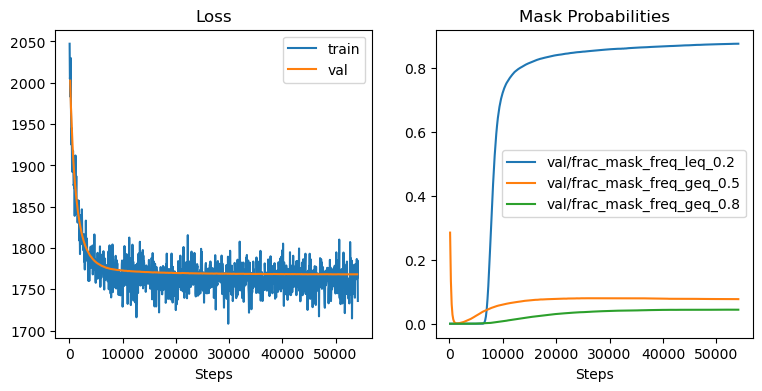

In [3]:
# still training...
plot_training_metrics("sams_vae_replogle")

In [4]:
lightning_module = load_checkpoint("sams_vae_replogle", best=False)

epoch=362-step=54000-val_loss=1768.28.ckpt


In [5]:
latent_vars = get_latent_vars(lightning_module)

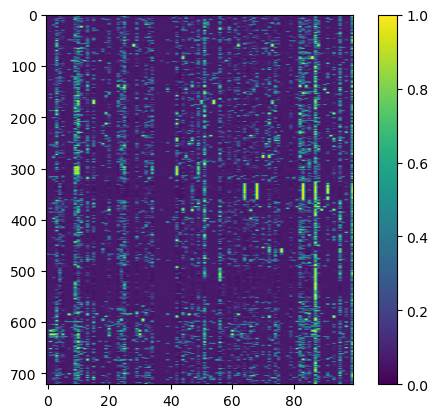

In [6]:
plt.imshow(latent_vars["mask_probs"], aspect=1/6, vmin=0, vmax=1)
plt.colorbar()

In [7]:
data_module = lightning_module.get_data_module()

In [8]:
# annotate treatments with pathways from Replogle et al.
t_var = data_module.get_d_var_info().copy()

t_var["i"] = np.arange(t_var.shape[0])
t_var["gene"] = [idx.split("_")[0] for idx in t_var.index]

pathway_map = {}
for k, v in data_module.adata.uns["pathways"].items():
    for gene in v:
        pathway_map[gene] = k
        
t_var["pathway"] = t_var["gene"].apply(lambda x: pathway_map.get(x))

t_var["pathway"].value_counts(dropna=False)

pathway
None                          377
S40_RIBOSOMAL_UNIT            101
S60_RIBOSOMAL_UNIT             56
S39_RIBOSOMAL_UNIT             44
SPLICEOSOME                    38
MT_PROTEIN_TRANSLOCATION       37
MEDIATOR_COMPLEX               26
NUCLEOTIDE_EXCISION_REPAIR     23
EXOSOME                        20
Name: count, dtype: int64

In [9]:
# info to sort embeddings by pathway
sorted_pathways = t_var.dropna(subset=["pathway"]).sort_values(["pathway", "gene"])
sorted_pathways["j"] = np.arange(sorted_pathways.shape[0])
idx = sorted_pathways["i"].to_numpy()
pathway_divisions = sorted_pathways.dropna(subset=["pathway"]).sort_values(["pathway", "gene"]).drop_duplicates("pathway")

In [10]:
pathway_divisions

cell_barcode,i,gene,pathway,j
CAMTA2_-_4890571.23-P1P2|CAMTA2_-_4890543.23-P1P2,48,CAMTA2,EXOSOME,0
ADAM10_+_59041886.23-P1P2|ADAM10_-_59041703.23-P1P2,11,ADAM10,MEDIATOR_COMPLEX,20
AARS_+_70323362.23-P1P2|AARS_-_70323332.23-P1P2,2,AARS,MT_PROTEIN_TRANSLOCATION,46
C1QBP_-_5342366.23-P1P2|C1QBP_-_5342105.23-P1P2,43,C1QBP,NUCLEOTIDE_EXCISION_REPAIR,83
AARS2_+_44281027.23-P1P2|AARS2_+_44281044.23-P1P2,1,AARS2,S39_RIBOSOMAL_UNIT,106
AAR2_-_34824434.23-P1P2|AAR2_+_34824488.23-P1P2,0,AAR2,S40_RIBOSOMAL_UNIT,150
ABCF1_+_30539238.23-P1|ABCF1_+_30539469.23-P1,4,ABCF1,S60_RIBOSOMAL_UNIT,251
CLNS1A_-_77348773.23-P1P2|CLNS1A_-_77348782.23-P1P2,76,CLNS1A,SPLICEOSOME,307


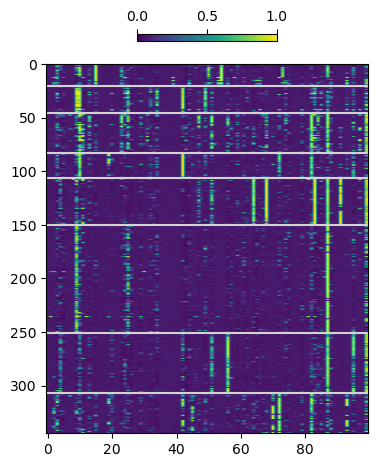

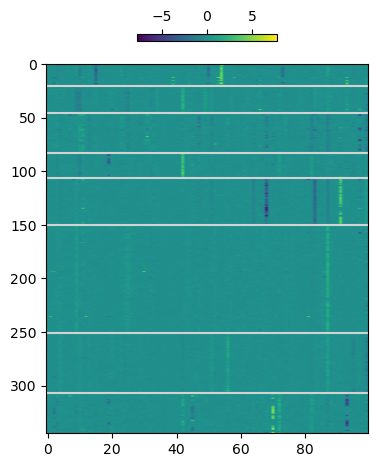

In [11]:
mask_probs = latent_vars["mask_probs"]
E_mean = latent_vars["E_mean"]

if mask_probs is not None:
    plt.figure(figsize=(6,6))
    plt.imshow(mask_probs[idx], vmin=0, vmax=1, aspect=1/3)
    for j in pathway_divisions["j"]:
        if j == 0:
            continue
        plt.axhline(y=j, c="lightgray")
    plt.colorbar(location="top", shrink=0.3)
    plt.show(plt.gcf())
    plt.close()
    
if E_mean is not None:
    plt.figure(figsize=(6,6))
    plt.imshow(E_mean[idx], aspect=1/3, norm=colors.CenteredNorm())
    for j in pathway_divisions["j"]:
        if j == 0:
            continue
        plt.axhline(y=j, c="lightgray")
    plt.colorbar(location="top", shrink=0.3)
    plt.show(plt.gcf())
    plt.close()